In [77]:
import pandas as pd
import numpy as np
import random

from pprint import pprint

In [78]:
df = pd.read_csv(r'./data/preprocess.csv')

df.head()

,IDX,mean_ndvi_2022-06-02,mean_ndvi_2022-06-17,mean_ndvi_2022-06-07,mean_ndvi_2022-06-22,mean_ndvi_2022-06-12,mean_ndre_2022-06-02,mean_ndre_2022-06-17,mean_ndre_2022-06-07,mean_ndre_2022-06-12,IDX.1,sum_ndvi_2022-06-02,sum_ndvi_2022-06-17,sum_ndvi_2022-06-07,sum_ndvi_2022-06-22,sum_ndvi_2022-06-12,sum_ndre_2022-06-02,sum_ndre_2022-06-17,sum_ndre_2022-06-07,sum_ndre_2022-06-12
0,3942,0.007476,0.212770,0.180844,0.038478,0.219896,-0.017073,0.151714,0.123746,0.153333,3942,0.530825,15.106694,12.839933,2.731913,15.612608,-1.212181,10.771678,8.785966,10.886635
1,4053,0.008709,0.202058,0.165046,-0.019584,0.198812,-0.007738,0.134886,0.106043,0.128798,4053,1.689533,39.199349,32.018860,-3.799293,38.569600,-1.501124,26.167940,20.572346,24.986805
2,4196,0.204576,0.192939,0.156745,-0.011448,0.186642,0.226347,0.128658,0.095656,0.117090,4196,19.639275,18.522111,15.047543,-1.099016,17.917662,21.729303,12.351145,9.183014,11.240659
3,4422,-0.001838,0.198717,0.181343,-0.002894,0.215428,-0.036878,0.132829,0.113879,0.136089,4422,-0.104746,11.326846,10.336535,-0.164956,12.279409,-2.102046,7.571269,6.491099,7.757051
4,4424,-0.046762,0.205482,0.185708,-0.005377,0.218237,-0.094255,0.145178,0.124556,0.148208,4424,-1.730197,7.602816,6.871180,-0.198932,8.074769,-3.487440,5.371600,4.608560,5.483689


In [79]:
target = pd.read_csv('./data/target_PROD.csv')

In [80]:
X = pd.read_csv(r'./preprocess.csv')

y = target['PROD']

En este último punto vamos a realizar un estudio de las correlaciones entre los índices que han llegado a la vista minable que utilizamos. Procedemos con un análisis de componentes principales, visualizamos algunas de las relaciones entre las columnas. Utilizamos el mejor modelo estudio con sus mejores hyperparámetros y dejaremos un puequeño script para predecir los resultados a partir de los datos que tenemos y el modelo estudiado.

In [81]:
# puede que sea importante reducir la dimensionalidad:

from sklearn.model_selection import train_test_split

In [82]:
SEED = 42

X_train, X_test, y_train, y_test= train_test_split(
    
    X,y,
    train_size   = 0.8,
    random_state = SEED,
)

In [83]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = df.select_dtypes(include=['float64', 'int']).corr(method='pearson')

display(tidy_corr_matrix(corr_matrix))

,variable_1,variable_2,r,abs_r
200,IDX.1,IDX,1.000000,1.000000
10,IDX,IDX.1,1.000000,1.000000
257,sum_ndvi_2022-06-17,sum_ndre_2022-06-17,0.999206,0.999206
352,sum_ndre_2022-06-17,sum_ndvi_2022-06-17,0.999206,0.999206
395,sum_ndre_2022-06-12,sum_ndvi_2022-06-12,0.998884,0.998884
...,...,...,...,...
40,mean_ndvi_2022-06-17,IDX,0.023588,0.023588
161,mean_ndre_2022-06-07,mean_ndvi_2022-06-02,0.013912,0.013912
28,mean_ndvi_2022-06-02,mean_ndre_2022-06-07,0.013912,0.013912
282,sum_ndvi_2022-06-22,mean_ndvi_2022-06-17,0.000458,0.000458


### PCA_reg

In [84]:

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import multiprocessing

In [85]:
pca_pipe = make_pipeline(StandardScaler(), PCA())

pca_pipe.fit(df)

modelo_pca = pca_pipe.named_steps['pca']

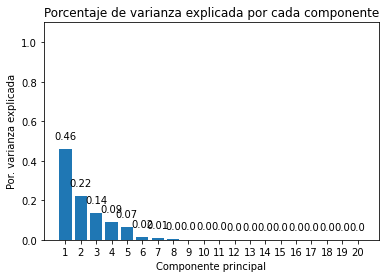

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

In [87]:
# Entrenamiento modelo de regresión precedido por PCA con escalado

pipe_modelado = make_pipeline(StandardScaler(), PCA(), LinearRegression())

pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])

In [88]:
pipe_modelado.set_params

<bound method Pipeline.set_params of Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])>

In [89]:
# Predicciones test
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
rmse_pcr = mean_squared_error(

            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
)

print("")

print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 23161.668257269517


In [90]:
import warnings

warnings.filterwarnings('ignore')

In [91]:
# Grid de hiperparámetros evaluados
param_grid = {'pca__n_components': [1, 2, 4, 6, 8, 10, 15, 20, 30, 50]}

# Búsqueda por grid search con validación cruzada
grid = GridSearchCV(

        estimator  = pipe_modelado,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = KFold(n_splits=5), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
)

grid.fit(X = X_train, y = y_train)

resultados = pd.DataFrame(grid.cv_results_)

resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

,param_pca__n_components,mean_test_score,std_test_score,mean_train_score,std_train_score
3,6,-4008.962109,1175.902367,-3101.094909,253.514638
1,2,-4113.112191,963.991483,-3817.906030,159.534116
2,4,-4204.323051,1096.227656,-3508.451517,283.075496
0,1,-4217.893218,739.222846,-4051.039661,189.573614
4,8,-4687.197056,1785.019526,-2733.908326,321.662338


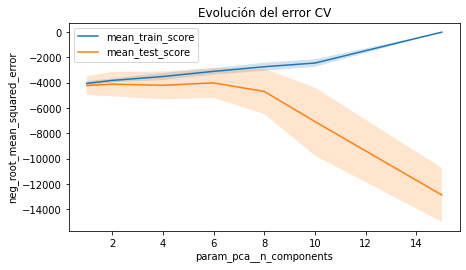

In [92]:
# Gráfico resultados validación cruzada para cada hiperparámetro

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.84), sharey=True)

resultados.plot('param_pca__n_components', 'mean_train_score', ax=ax)
resultados.plot('param_pca__n_components', 'mean_test_score', ax=ax)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel('neg_root_mean_squared_error');

In [93]:
# UTILIZAMOS LA RED NEURONAL ENCONTRADA COMO MODELO FINAL:

Finalmente nos quedamos con la red neuronal encontrada como mejor modelo para predecir los kg de producción para un cultivo. 

In [94]:
import warnings

warnings.filterwarnings('ignore')

In [95]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import KFold

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

param_grid = {
    
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(MLPRegressor(), param_grid, n_jobs= -1, cv=5)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(150, 100, 50), (120, 80, 40),
                                                (100, 50, 30)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [50, 100], 'solver': ['sgd', 'adam']})

In [97]:
scaler=StandardScaler()
x_train=scaler.fit_transform(X_train)
x_test=scaler.transform(X_test)

In [98]:
mlp=MLPRegressor(**grid.best_params_)

pipeline=Pipeline([('transformer',scaler),('estimator',mlp)])

pipeline.fit(X_train,y_train)

cv=KFold(n_splits=5)

scores_crossval=cross_val_score(pipeline,x_test,y_test,cv=cv)

In [99]:
# Score and prediction:

score = pipeline.score(X_test, y_test)

predicted_y = pipeline.predict(X_test)

In [100]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predicted_y))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predicted_y))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted_y)))

Mean Absolute Error: 8991.64822779183
Mean Squared Error: 177974786.52715164
Root Mean Squared Error: 13340.719115817994
